In [17]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

pd.options.display.float_format = '{:,.2f}'.format

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

def beautify_columns(dataframe, column_numbers, symbol):
    for column_number in column_numbers:
        # Transformar em string
        for i in np.arange(0, len(dataframe.index)):
            dataframe.iloc[i , column_number] = \
            str(round(dataframe.iloc[i , column_number], 2))

            # Se for 0, passar a se 0.00 + symbol
            if dataframe.iloc[i , column_number] == '0':
                dataframe.iloc[i , column_number] = '0.00' + symbol
                
            # Se só tem 1 número a seguir ao ponto acrescentar um zero
            # (para ter duas casa decimais) e o símbolo do euro
            if len(dataframe.iloc[i , column_number].partition('.')[2]) < 2:
                dataframe.iloc[i , column_number] = \
                dataframe.iloc[i , column_number].partition('.')[0] \
                + dataframe.iloc[i , column_number].partition('.')[1] \
                + dataframe.iloc[i , column_number].partition('.')[2][0:1] \
                + '0' + symbol
                
            # Se já tem 2 duas casas decimais acrescentar só o símbolo de euro
            if len(dataframe.iloc[i , column_number].partition('.')[2]) >= 2 \
            and symbol not in dataframe.iloc[i , column_number]:
                dataframe.iloc[i , column_number] =\
                dataframe.iloc[i , column_number] + symbol
                
            # Se tem mais de 3 casas antes do ponto acrescentar uma vírgula
            # a representar milhares
            if len(dataframe.iloc[i , column_number].partition('.')[0]) > 3:
                dataframe.iloc[i , column_number] = \
                dataframe.iloc[i , column_number].partition('.')[0][:-3] \
                + ',' \
                + dataframe.iloc[i , column_number].partition('.')[0][-3:] \
                + dataframe.iloc[i , column_number].partition('.')[1] \
                + dataframe.iloc[i , column_number].partition('.')[2]
                
            # Se tem mais de 6 casas antes do ponto fazer uma virgula de milhões
            if len(dataframe.iloc[i , column_number].partition('.')[0]) > 7:
                dataframe.iloc[i , column_number] =\
                dataframe.iloc[i , column_number].partition(',')[0][:-3] \
                + ',' \
                + dataframe.iloc[i , column_number].partition(',')[0][-3:] \
                + dataframe.iloc[i , column_number].partition(',')[1] \
                + dataframe.iloc[i , column_number].partition(',')[2] 


In [18]:
CRUDP = pd.read_excel('CRUDP.xlsx', skiprows=[0, 1, 2, 3, 4, 5], index_col='Dates', parse_dates=True)[['PX_LAST']]
CRUDP.columns=['CRUDP']

In [19]:
dimensions=(990, 500)
# CRUDP.iplot(dimensions=dimensions)

In [20]:
import quandl 

OIL = quandl.get("OPEC/ORB", authtoken="HU7i-qDWTo-fWcBzRZ_f")
OIL.columns=['Oil']

EUR_USD = quandl.get("ECB/EURUSD", authtoken="HU7i-qDWTo-fWcBzRZ_f")
EUR_USD.columns=['EUR/USD']

In [21]:
ISINs = ['USO.EUR']
Nomes = ['USO.EUR']

fundos = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Backtester/Data/Cotacoes_diarias.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()

In [22]:
Fundos = CRUDP.merge(OIL, left_index = True, right_index = True, how='inner')
Fundos = Fundos.merge(EUR_USD, left_index = True, right_index = True, how='inner')
Fundos = Fundos.merge(fundos, left_index = True, right_index = True, how='inner')

In [23]:
Fundos['Oil_eur'] = Fundos['Oil'] / Fundos['EUR/USD']
Fundos = Fundos[['CRUDP', 'Oil_eur', 'USO.EUR']]

In [24]:
Fundos = (Fundos/Fundos.iloc[0]) * 100

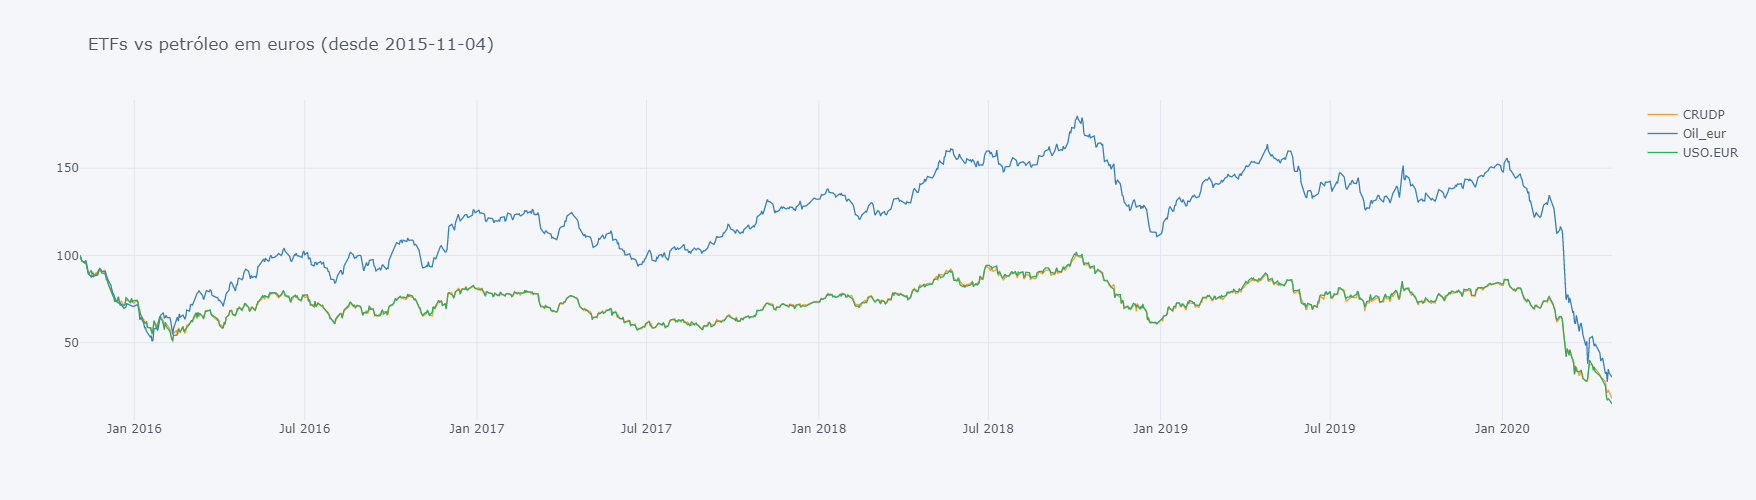

In [25]:
Fundos.iplot(dimensions=dimensions, title='ETFs vs petróleo em euros (desde 2015-11-04)')

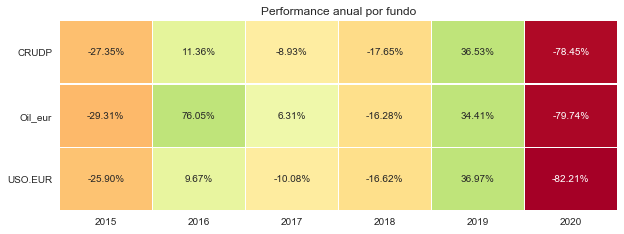

In [26]:
fundos_norm= Fundos.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([fundos_norm.iloc[:1], yearly_quotes_fundos])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Inverter o sentido das rows no dataframe ####
yearly_returns_fundos = yearly_returns_fundos / 100 # A alterar para incluir 2001

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(10, 3.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0, fmt='.2%', vmax=0.25)
plt.yticks(rotation=360)
plt.title('Performance anual por fundo');

In [27]:
def all_percent(df):
    for column in df.columns:
        df[column] = round(df[column], 2).apply( lambda x : str(x) + '%')
    
    return df

yearly_returns_fundos_percentage = (yearly_returns_fundos * 100).transpose()
all_percent(yearly_returns_fundos_percentage)

yearly_returns_fundos_percentage

,2015,2016,2017,2018,2019,2020
CRUDP,-27.35%,11.36%,-8.93%,-17.65%,36.53%,-78.45%
Oil_eur,-29.31%,76.05%,6.31%,-16.28%,34.41%,-79.74%
USO.EUR,-25.9%,9.67%,-10.08%,-16.62%,36.97%,-82.21%


In [28]:
Fundos_2017 = Fundos['2017-12-31':]
Fundos_2017 = (Fundos_2017/Fundos_2017.iloc[0]) * 100

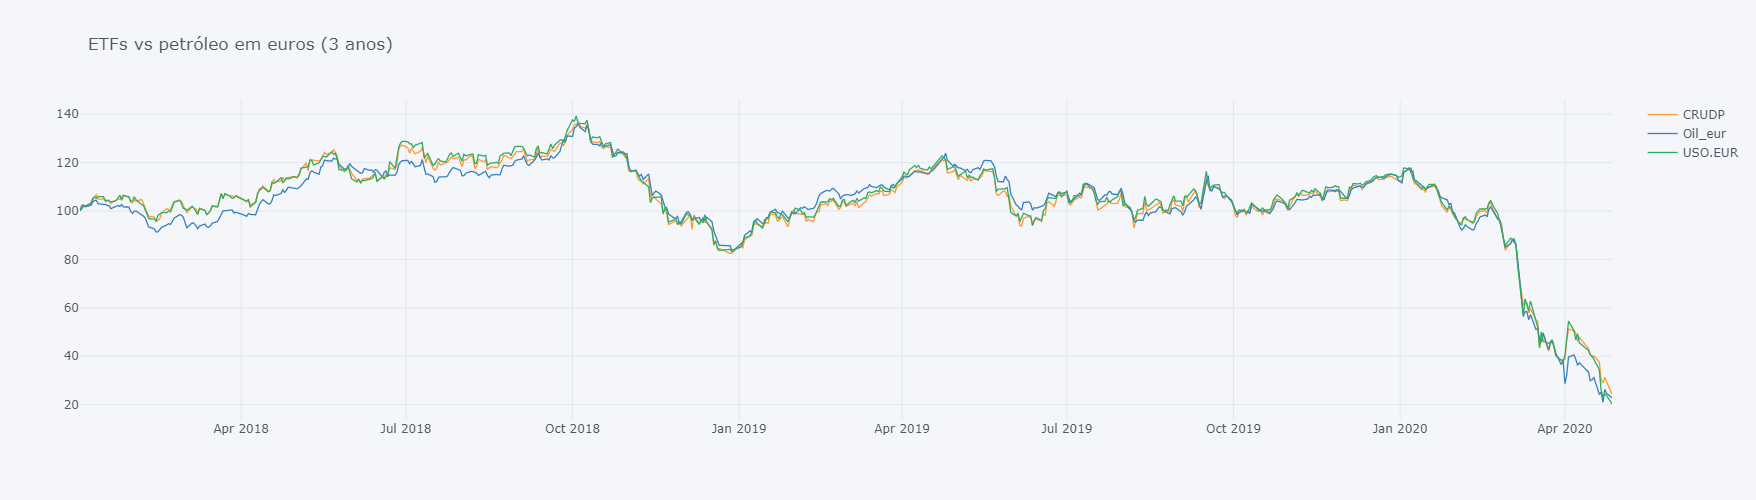

In [29]:
Fundos_2017.iplot(dimensions=dimensions, title='ETFs vs petróleo em euros (3 anos)')

In [31]:
Fundos_2020 = Fundos['2019-12-31':]
Fundos_2020 = (Fundos_2020/Fundos_2020.iloc[0]) * 100

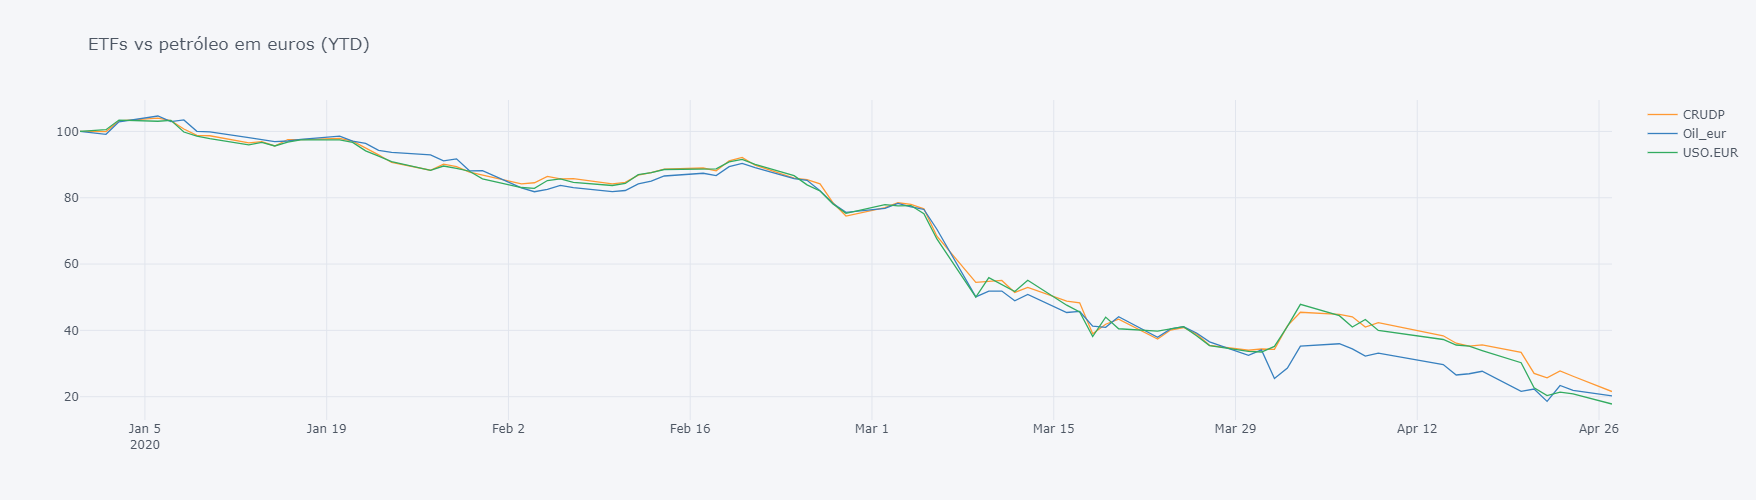

In [32]:
Fundos_2020.iplot(dimensions=dimensions, title='ETFs vs petróleo em euros (YTD)')

**Notas:** 
- Ao passar o rato por cima do gráfico aparecem opções (no canto superior direito). Opções relevantes são "Show closest data on hoover" ou "Compare data on hoover";
- Se clicarem na legendas o respectivo gráfico desaparece (muito útil para ver apenas duas séries temporais);
- Podem fazer zoom clicando e arrastando.

In [30]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF